## NREL WIND Toolkit - HSDS Data Export

This notebook demonstrates data export from the National Renewable Energy Laboratory (NREL) Wind Integration National Dataset (WIND) Toolkit data. The data is provided from Amazon Web Services using the HDF Group's Highly Scalable Data Service (HSDS).

For this to work you must first install h5pyd:

```
pip install --user git+http://github.com/HDFGroup/h5pyd.git
```

Then, you can make a configuration file at ~/.hscfg with contents like so:

```
# HDFCloud configuration file
hs_endpoint = https://developer.nrel.gov/api/hsds/
hs_username = None
hs_password = None
hs_api_key = 3K3JQbjZmWctY0xmIfSYvYgtIcM3CN0cb1Y2w9bf
```

*The example API key here is for demonstation and is rate-limited per IP. To get your own API key, visit https://developer.nrel.gov/signup/*

In [1]:
%matplotlib inline
import h5pyd
import pandas as pd
import dateutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import sys
sys.path.append('../lib')
# convenience functions
from functions import *

## Single Multivariate Timeseries

In [2]:
f = h5pyd.File("/nrel/wtk-us.h5", 'r')  
list(f)

[u'DIF',
 u'DNI',
 u'GHI',
 u'coordinates',
 u'datetime',
 u'inversemoninobukhovlength_2m',
 u'precipitationrate_0m',
 u'pressure_0m',
 u'pressure_100m',
 u'pressure_200m',
 u'relativehumidity_2m',
 u'status',
 u'temperature_100m',
 u'temperature_10m',
 u'temperature_120m',
 u'temperature_140m',
 u'temperature_160m',
 u'temperature_200m',
 u'temperature_2m',
 u'temperature_40m',
 u'temperature_60m',
 u'temperature_80m',
 u'winddirection_100m',
 u'winddirection_10m',
 u'winddirection_120m',
 u'winddirection_140m',
 u'winddirection_160m',
 u'winddirection_200m',
 u'winddirection_40m',
 u'winddirection_60m',
 u'winddirection_80m',
 u'windspeed_100m',
 u'windspeed_10m',
 u'windspeed_120m',
 u'windspeed_140m',
 u'windspeed_160m',
 u'windspeed_200m',
 u'windspeed_40m',
 u'windspeed_60m',
 u'windspeed_80m']

The following code fetches the full timeseries data for a given lat/lon for three variables. Since the datasets are stored separately and there's a limit of ~8000 values per request, this can be a bit slow to run.

In [3]:
LongsPeak_idx = indicesForCoord(f, 40.2549, -105.6160)
df = pd.DataFrame({"datetime": map(dateutil.parser.parse,f["datetime"][:]),
                   "temperature_100m": entireTimeseries(f['temperature_100m'],LongsPeak_idx[0],LongsPeak_idx[1]),
                   "windspeed_100m": entireTimeseries(f['windspeed_100m'],LongsPeak_idx[0],LongsPeak_idx[1]),
                   "pressure_100m": entireTimeseries(f['pressure_100m'],LongsPeak_idx[0],LongsPeak_idx[1])})
df.head()

,datetime,pressure_100m,temperature_100m,windspeed_100m
0,2007-01-01 00:00:00,63688.468750,266.147339,9.109772
1,2007-01-01 01:00:00,63682.058594,266.312134,10.260323
2,2007-01-01 02:00:00,63661.000000,266.220581,11.548203
3,2007-01-01 03:00:00,63645.437500,266.174805,11.844231
4,2007-01-01 04:00:00,63644.519531,265.955078,12.570572


In [4]:
# save data to csv
df.to_csv('longspeak.csv')

## All Within Bounding Box

In [5]:
def indicesForBBox(f, lat_range, lon_range):
    xmin = None
    xmax = None
    ymin = None
    ymax = None
    for i in [0,1]:
        for j in [0,1]:
            yx = indicesForCoord(f,lat_range[i],lon_range[j])
            if xmin is None or yx[1] < xmin:
                xmin = yx[1]
            if xmax is None or yx[1] > xmax:
                xmax = yx[1]
            if ymin is None or yx[0] < ymin:
                ymin = yx[0]
            if ymax is None or yx[0] > ymax:
                ymax = yx[0]
    return ([xmin,xmax],[ymin,ymax])

# This bounding box is the state of Colorado, more or less
(x_range,y_range) = indicesForBBox(f,[36.96744946416934,41.02964338716638],[-109.05029296875,-102.0849609375])

print "x range for Colorado = (%d,%d)" % (x_range[0],x_range[1])
print "y range for Colorado = (%d,%d)" % (y_range[0],y_range[1])

x range for Colorado = (924,1241)
y range for Colorado = (729,982)


In [6]:
# Get every other windspeed measurement within this box for a given time step
dtdf = datetimeIndex(f)
dset = f['windspeed_100m']
timestep = dtdf.loc[dtdf.datetime == '2012-04-01 12:00:00'].index[0]
%time data = dset[timestep,y_range[0]:y_range[1]:2,x_range[0]:x_range[1]:2]  # :2 means every second point

CPU times: user 3.78 ms, sys: 1.1 ms, total: 4.88 ms
Wall time: 456 ms


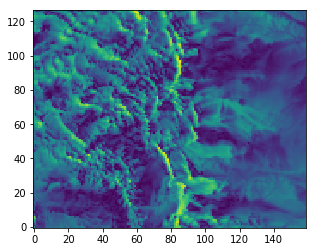

In [7]:
plt.imshow(data, origin="lower")

In [8]:
print "There are ..."
print "  %d points within this box a 2km resolution" % ((x_range[1]-x_range[0])*(y_range[1]-y_range[0]),)
print "  %d points within this box at 4km resolution" % ((x_range[1]-x_range[0])/2*(y_range[1]-y_range[0])/2,)
print "  %d points within this box at 8km resolution" % ((x_range[1]-x_range[0])/4*(y_range[1]-y_range[0])/4,)
print "  %d points within this box at 16km resolution" % ((x_range[1]-x_range[0])/8*(y_range[1]-y_range[0])/8,)

There are ...
  80201 points within this box a 2km resolution
  19987 points within this box at 4km resolution
  4996 points within this box at 8km resolution
  1233 points within this box at 16km resolution


In [9]:
# Monthly time series on the first day at noon into a numpy 3D matrix (cube)
spacing = 8 # every 8th point is 16km resolution
highnoon = dtdf[dtdf['datetime'].apply(lambda x: x.hour == 12 and x.day == 1)]
cube = np.zeros((len(highnoon),(y_range[1]-y_range[0])/spacing + 1,(x_range[1]-x_range[0])/spacing + 1), 
                dtype=dset.dtype)

# We must fetch the data iteratively due to limitation in request entity size
for t in highnoon.index:
    # fetch the data
    %time data = dset[t,y_range[0]:y_range[1]:spacing,x_range[0]:x_range[1]:spacing] # 16km windspeed data for this box
    # store it in the cube
    cube[np.where(highnoon.index == t)[0][0],:,:] = data

CPU times: user 2.85 ms, sys: 335 µs, total: 3.19 ms
Wall time: 2.13 s
CPU times: user 4.38 ms, sys: 1.12 ms, total: 5.5 ms
Wall time: 417 ms
CPU times: user 3.81 ms, sys: 762 µs, total: 4.57 ms
Wall time: 521 ms
CPU times: user 3.9 ms, sys: 1.19 ms, total: 5.09 ms
Wall time: 627 ms
CPU times: user 3.96 ms, sys: 1.05 ms, total: 5.01 ms
Wall time: 415 ms
CPU times: user 3.79 ms, sys: 1.05 ms, total: 4.84 ms
Wall time: 1.15 s
CPU times: user 3.39 ms, sys: 672 µs, total: 4.07 ms
Wall time: 682 ms
CPU times: user 3.73 ms, sys: 797 µs, total: 4.53 ms
Wall time: 429 ms
CPU times: user 3.94 ms, sys: 929 µs, total: 4.86 ms
Wall time: 556 ms
CPU times: user 3.9 ms, sys: 783 µs, total: 4.68 ms
Wall time: 520 ms
CPU times: user 3.9 ms, sys: 798 µs, total: 4.69 ms
Wall time: 520 ms
CPU times: user 3.54 ms, sys: 772 µs, total: 4.31 ms
Wall time: 521 ms
CPU times: user 4.35 ms, sys: 947 µs, total: 5.3 ms
Wall time: 521 ms
CPU times: user 3.4 ms, sys: 887 µs, total: 4.29 ms
Wall time: 624 ms
CPU time

In [10]:
# Convert data cube to a datafame where each location is a column
ll_for_coords = f['coordinates'][y_range[0]:y_range[1]:spacing,x_range[0]:x_range[1]:spacing]
df = pd.DataFrame({"datetime": highnoon["datetime"] })
for i in range(len(ll_for_coords)):
    for j in range(len(ll_for_coords[i])):
        colname = "%.03f,%.03f" % (ll_for_coords[i][j][1],ll_for_coords[i][j][0])
        df[colname] = cube[:,i,j]
        
df.head()

,datetime,"-108.918,36.314","-108.738,36.337","-108.558,36.360","-108.377,36.383","-108.196,36.406","-108.016,36.428","-107.835,36.450","-107.654,36.471","-107.472,36.492",...,"-104.031,41.443","-103.834,41.458","-103.637,41.472","-103.439,41.486","-103.242,41.500","-103.044,41.513","-102.846,41.526","-102.648,41.538","-102.450,41.551","-102.252,41.562"
12,2007-01-01 12:00:00,0.466934,0.515762,1.211586,8.954132,8.859520,8.142342,8.557388,9.445480,7.263405,...,9.842216,9.723198,10.443436,11.029388,10.513626,6.717125,5.331581,2.407913,5.893127,5.301064
756,2007-02-01 12:00:00,8.221687,7.104706,7.522812,5.941956,8.697777,9.161659,9.811699,10.934784,8.957184,...,12.262337,10.492264,11.014130,10.904266,10.263374,10.641808,7.144386,6.646935,9.372238,7.705925
1428,2007-03-01 12:00:00,13.766899,11.716057,10.116882,7.473984,10.705894,4.950104,7.773064,11.725212,11.328468,...,10.492264,8.331551,7.547226,7.644890,7.055878,7.361061,7.037567,7.535019,6.195259,6.405838
2172,2007-04-01 12:00:00,12.213509,0.659203,1.440475,1.684624,3.155617,3.906372,2.871788,2.771080,2.819908,...,13.385422,16.226692,16.534927,15.051727,13.190102,6.357002,8.481094,10.452591,12.198250,11.374252
2892,2007-05-01 12:00:00,0.558487,1.644951,2.682579,4.748680,5.178993,6.411942,5.493332,4.742577,6.738487,...,3.274635,3.015228,6.027405,5.883972,6.692711,7.956177,6.024353,9.204384,8.395645,11.658073


In [11]:
df.to_csv("colorado.csv")